In [1]:
import numpy as np
import h5py
import time
import json
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.v2 as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
x_train_path = "/kaggle/input/pcam-dataset/camelyonpatch_level_2_split_train_x.h5"
y_train_path = "/kaggle/input/pcam-dataset/camelyonpatch_level_2_split_train_y.h5"

x_valid_path = "/kaggle/input/pcam-dataset/camelyonpatch_level_2_split_valid_x.h5"
y_valid_path = "/kaggle/input/pcam-dataset/camelyonpatch_level_2_split_valid_y.h5"

x_test_path = "/kaggle/input/pcam-dataset/camelyonpatch_level_2_split_test_x.h5"
y_test_path = "/kaggle/input/pcam-dataset/camelyonpatch_level_2_split_test_y.h5"

In [3]:
class PCamDataset(Dataset):
    def __init__(self, x_path, y_path, transform):
        self.transform = transform

        with h5py.File(x_path, "r") as file_x, h5py.File(y_path, "r") as file_y:
            self.images = file_x["x"][:]
            self.labels = file_y["y"][:]

        self.length = len(self.images)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        img = self.images[index]
        label = self.labels[index]

        img = self.transform(img)
        label = torch.tensor(label, dtype=torch.float32).squeeze()

        return img, label

In [4]:
def compute_metrics(labels, preds, probs):
    labels = np.array(labels)
    preds = np.array(preds)
    probs = np.array(probs)

    accuracy = 100 * accuracy_score(labels, preds)

    if np.sum(preds) == 0:
        precision = 0.0
        recall = 0.0
        f1 = 0.0
    else:
        precision = precision_score(labels, preds, average="binary")
        recall = recall_score(labels, preds, average="binary")
        f1 = f1_score(labels, preds, average="binary")

    if np.sum(labels) == 0 or np.sum(preds) == 0:
        roc_auc = 0.0
        pr_auc = 0.0
    else:
        roc_auc = roc_auc_score(labels, probs)
        pr_auc = average_precision_score(labels, probs)

    return {
        "accuracies": accuracy,
        "precisions": precision,
        "recalls": recall,
        "f1s": f1,
        "rocs": roc_auc,
        "prs": pr_auc,
    }


def round_metrics(metrics, decimals=4):
    def round_value(value):
        if isinstance(value, float):
            return round(value, decimals)
        elif isinstance(value, list):
            return [round_value(v) for v in value]
        elif isinstance(value, tuple):
            return tuple(round_value(v) for v in value)
        elif isinstance(value, dict):
            return {k: round_value(v) for k, v in value.items()}
        return value

    return {key: round_value(values) for key, values in metrics.items()}

In [5]:
def plot_metrics(epochs_range, train_vals, val_vals, ylabel, title):
    plt.plot(epochs_range, train_vals, label="Train")
    plt.plot(epochs_range, val_vals, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()

In [6]:
def test_model(model, test_loader):
    running_test_loss = 0.0
    test_preds, test_labels, test_probs = [], [], []

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Testing", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze(dim=1)
            loss = criterion(outputs, labels)

            running_test_loss += loss.item()
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).long()

            test_preds.extend(predicted.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
            test_probs.extend(probs.detach().cpu().numpy())

    running_test_loss /= len(test_loader)
    test_metrics = compute_metrics(test_labels, test_preds, test_probs)

    print(
        f"Test Loss: {running_test_loss:.4f}, "
        f"Acc: {test_metrics['accuracies']:.4f}%, "
        f"F1: {test_metrics['f1s']:.4f}\n"
    )

    return test_metrics

In [7]:
def train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, epochs
):
    metrics = {
        "losses": ([], []),
        "accuracies": ([], []),
        "precisions": ([], []),
        "recalls": ([], []),
        "f1s": ([], []),
        "rocs": ([], []),
        "prs": ([], []),
    }

    test_metrics = {}
    best_test_accuracy = 0.0

    total_train_time, total_val_time = 0, 0

    for epoch in range(1, epochs + 1):
        model.train()
        start_time = time.time()
        running_train_loss = 0.0
        train_preds, train_labels, train_probs = [], [], []

        for images, labels in tqdm(
            train_loader, desc=f"Epoch {epoch}/{epochs} - Training", leave=False
        ):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images).squeeze(dim=1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).long()

            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
            train_probs.extend(probs.detach().cpu().numpy())

        total_train_time += time.time() - start_time
        train_metrics = compute_metrics(train_labels, train_preds, train_probs)

        if scheduler is not None:
            scheduler.step()

        model.eval()
        with torch.no_grad():
            start_time = time.time()
            running_val_loss = 0.0
            val_preds, val_labels, val_probs = [], [], []

            for images, labels in tqdm(
                val_loader, desc=f"Epoch {epoch}/{epochs} - Validation", leave=False
            ):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).squeeze(dim=1)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()
                probs = torch.sigmoid(outputs)
                predicted = (probs > 0.5).long()

                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                val_probs.extend(probs.detach().cpu().numpy())

            total_val_time += time.time() - start_time
            val_metrics = compute_metrics(val_labels, val_preds, val_probs)

        running_train_loss /= len(train_loader)
        running_val_loss /= len(val_loader)

        metrics["losses"][0].append(running_train_loss)
        metrics["losses"][1].append(running_val_loss)

        for key in metrics.keys():
            if key != "losses":
                metrics[key][0].append(train_metrics[key])
                metrics[key][1].append(val_metrics[key])

        print(
            f"Epoch [{epoch}/{epochs}]:\n"
            f"Train Loss: {metrics['losses'][0][-1]:.4f}, "
            f"Acc: {metrics['accuracies'][0][-1]:.4f}%, "
            f"F1: {metrics['f1s'][0][-1]:.4f}\n"
            f"Val Loss: {metrics['losses'][1][-1]:.4f}, "
            f"Acc: {metrics['accuracies'][1][-1]:.4f}%, "
            f"F1: {metrics['f1s'][1][-1]:.4f}\n"
        )

        if epoch == 10 or epoch == 15 or epoch == 25:
            checkpoint = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": (
                    scheduler.state_dict() if scheduler is not None else None
                ),
            }
            torch.save(checkpoint, f"model_{epoch}.pth")

        test_met = test_model(model, test_loader)
        test_metrics[f"Testing_{epoch}"] = test_met

        test_accuracy = test_met["accuracies"]

        if epoch == 10 or epoch == 15 or epoch == 25:
            print(f"Test Accuracy at epoch: {epoch} is {test_accuracy} %\n")
            
        if test_accuracy >= best_test_accuracy:
            best_test_accuracy = test_accuracy
            print(f"Best Model saving at epoch: {epoch} with accuracy: {test_accuracy} %\n")
            checkpoint = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": (
                    scheduler.state_dict() if scheduler is not None else None
                ),
            }
            torch.save(checkpoint, f"model_best.pth")

    total_train_time /= 60
    total_val_time /= 60

    print(f"Best Test accuracy: {best_test_accuracy} %\n")
    print(
        f"Total Training Time: {(total_train_time):.2f} min, Validation Time: {(total_val_time):.2f} min"
    )

    metrics["total_times"] = {
        "training_time (mins)": total_train_time,
        "validation_time (mins)": total_val_time,
    }
    metrics["Testing"] = test_metrics

    return metrics

In [8]:
train_transform = transforms.Compose([
    transforms.ToImage(),
    transforms.RandomResizedCrop(size=(96, 96), scale=(0.85, 1.0)),  # Slight cropping variation
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=90),  # Rotations in histology images are common
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=10),  # Minor geometric changes
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),  # Color variations
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),  # Mimic stain variations
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose(
    [
        transforms.ToImage(),
        transforms.Resize((96, 96)),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

train_dataset = PCamDataset(x_train_path, y_train_path, transform=train_transform)
val_dataset = PCamDataset(x_valid_path, y_valid_path, transform=test_transform)
test_dataset = PCamDataset(x_test_path, y_test_path, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)

In [9]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)

model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25, eta_min=0.0001)

epochs = 25

print(model)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 221MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Epoch [1/25]:
Train Loss: 0.3250, Acc: 86.1084%, F1: 0.8600
Val Loss: 0.2942, Acc: 87.3688%, F1: 0.8750



Test Loss: 0.2551, Acc: 89.6179%, F1: 0.8981

Best Model saving at epoch: 1 with accuracy: 89.617919921875 %



Epoch [2/25]:
Train Loss: 0.2624, Acc: 89.2490%, F1: 0.8913
Val Loss: 0.3186, Acc: 87.0422%, F1: 0.8670



Test Loss: 0.3347, Acc: 86.0168%, F1: 0.8523



Epoch [3/25]:
Train Loss: 0.2370, Acc: 90.4842%, F1: 0.9038
Val Loss: 0.3294, Acc: 86.9812%, F1: 0.8588



Test Loss: 0.3341, Acc: 86.1755%, F1: 0.8482



Epoch [4/25]:
Train Loss: 0.2203, Acc: 91.2529%, F1: 0.9115
Val Loss: 0.2775, Acc: 89.2120%, F1: 0.8861



Test Loss: 0.2967, Acc: 88.0066%, F1: 0.8703



Epoch [5/25]:
Train Loss: 0.2089, Acc: 91.7313%, F1: 0.9163
Val Loss: 0.2943, Acc: 88.7695%, F1: 0.8799



Test Loss: 0.3674, Acc: 85.7697%, F1: 0.8412



Epoch [6/25]:
Train Loss: 0.1986, Acc: 92.2779%, F1: 0.9219
Val Loss: 0.3204, Acc: 88.5254%, F1: 0.8776



Test Loss: 0.3476, Acc: 87.1643%, F1: 0.8595



Epoch [7/25]:
Train Loss: 0.1893, Acc: 92.6388%, F1: 0.9256
Val Loss: 0.3234, Acc: 88.7604%, F1: 0.8796



Test Loss: 0.3609, Acc: 86.2274%, F1: 0.8475



Epoch [8/25]:
Train Loss: 0.1822, Acc: 92.9401%, F1: 0.9287
Val Loss: 0.3038, Acc: 88.4888%, F1: 0.8759



Test Loss: 0.3010, Acc: 88.1866%, F1: 0.8710



Epoch [9/25]:
Train Loss: 0.1749, Acc: 93.2945%, F1: 0.9322
Val Loss: 0.3353, Acc: 88.1073%, F1: 0.8721



Test Loss: 0.3582, Acc: 87.7747%, F1: 0.8665



Epoch [10/25]:
Train Loss: 0.1671, Acc: 93.5650%, F1: 0.9350
Val Loss: 0.2869, Acc: 88.8611%, F1: 0.8799



Test Loss: 0.3805, Acc: 85.7635%, F1: 0.8402

Test Accuracy at epoch: 10 is 85.7635498046875 %



Epoch [11/25]:
Train Loss: 0.1625, Acc: 93.8160%, F1: 0.9375
Val Loss: 0.3093, Acc: 88.9771%, F1: 0.8818



Test Loss: 0.3829, Acc: 86.1420%, F1: 0.8451



Epoch [12/25]:
Train Loss: 0.1560, Acc: 94.0857%, F1: 0.9403
Val Loss: 0.2832, Acc: 89.6118%, F1: 0.8892



Test Loss: 0.3395, Acc: 87.7167%, F1: 0.8650



Epoch [13/25]:
Train Loss: 0.1502, Acc: 94.3596%, F1: 0.9430
Val Loss: 0.3789, Acc: 86.7584%, F1: 0.8525



Test Loss: 0.3604, Acc: 86.4563%, F1: 0.8473



Epoch [14/25]:
Train Loss: 0.1472, Acc: 94.4859%, F1: 0.9444
Val Loss: 0.3130, Acc: 88.7512%, F1: 0.8787



Test Loss: 0.3779, Acc: 86.4990%, F1: 0.8493



Epoch [15/25]:
Train Loss: 0.1408, Acc: 94.7819%, F1: 0.9474
Val Loss: 0.2797, Acc: 89.6240%, F1: 0.8895



Test Loss: 0.3623, Acc: 87.5763%, F1: 0.8643

Test Accuracy at epoch: 15 is 87.5762939453125 %



Epoch [16/25]:
Train Loss: 0.1351, Acc: 94.9776%, F1: 0.9494
Val Loss: 0.2947, Acc: 89.5020%, F1: 0.8863



Test Loss: 0.3634, Acc: 86.8713%, F1: 0.8530



Epoch [17/25]:
Train Loss: 0.1312, Acc: 95.1572%, F1: 0.9512
Val Loss: 0.3178, Acc: 88.9313%, F1: 0.8810



Test Loss: 0.3822, Acc: 87.0575%, F1: 0.8564



Epoch [18/25]:
Train Loss: 0.1261, Acc: 95.3747%, F1: 0.9534
Val Loss: 0.3047, Acc: 89.6240%, F1: 0.8898



Test Loss: 0.3234, Acc: 88.4918%, F1: 0.8750



Epoch [19/25]:
Train Loss: 0.1223, Acc: 95.5040%, F1: 0.9547
Val Loss: 0.3185, Acc: 89.0289%, F1: 0.8811



Test Loss: 0.4031, Acc: 86.0626%, F1: 0.8426



Epoch [20/25]:
Train Loss: 0.1195, Acc: 95.6203%, F1: 0.9559
Val Loss: 0.3267, Acc: 88.7878%, F1: 0.8779



Test Loss: 0.4143, Acc: 86.1023%, F1: 0.8430



Epoch [21/25]:
Train Loss: 0.1172, Acc: 95.7428%, F1: 0.9571
Val Loss: 0.3138, Acc: 88.8306%, F1: 0.8788



Test Loss: 0.3682, Acc: 86.8500%, F1: 0.8533



Epoch [22/25]:
Train Loss: 0.1137, Acc: 95.8847%, F1: 0.9585
Val Loss: 0.3617, Acc: 88.4705%, F1: 0.8748



Test Loss: 0.3710, Acc: 87.7930%, F1: 0.8651



Epoch [23/25]:
Train Loss: 0.1116, Acc: 95.9312%, F1: 0.9590
Val Loss: 0.3644, Acc: 88.3759%, F1: 0.8725



Test Loss: 0.4258, Acc: 86.5570%, F1: 0.8485



Epoch [24/25]:
Train Loss: 0.1103, Acc: 96.0171%, F1: 0.9599
Val Loss: 0.3340, Acc: 88.9923%, F1: 0.8806



Test Loss: 0.3930, Acc: 87.2864%, F1: 0.8584



Epoch [25/25]:
Train Loss: 0.1086, Acc: 96.0693%, F1: 0.9604
Val Loss: 0.3429, Acc: 89.0228%, F1: 0.8813



Test Loss: 0.4068, Acc: 86.7889%, F1: 0.8523

Test Accuracy at epoch: 25 is 86.7889404296875 %

Best Test accuracy: 89.617919921875 %

Total Training Time: 271.02 min, Validation Time: 6.50 min


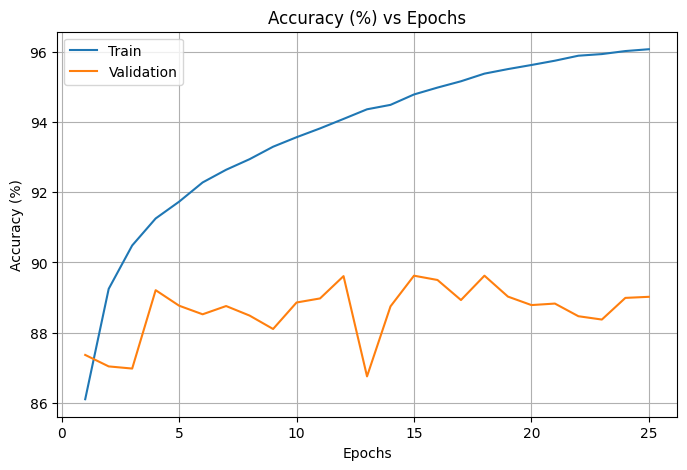

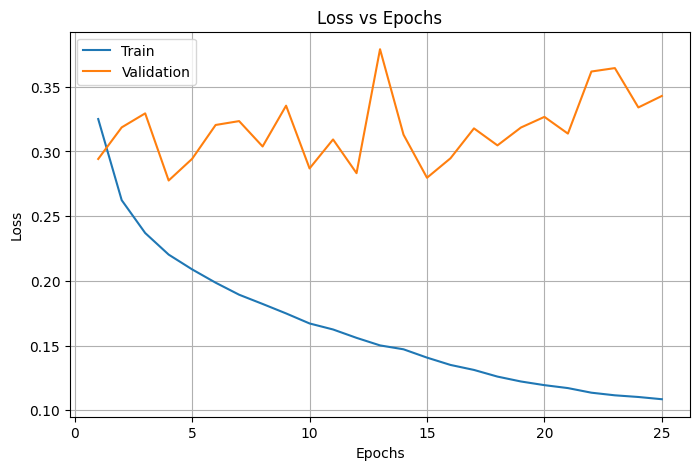

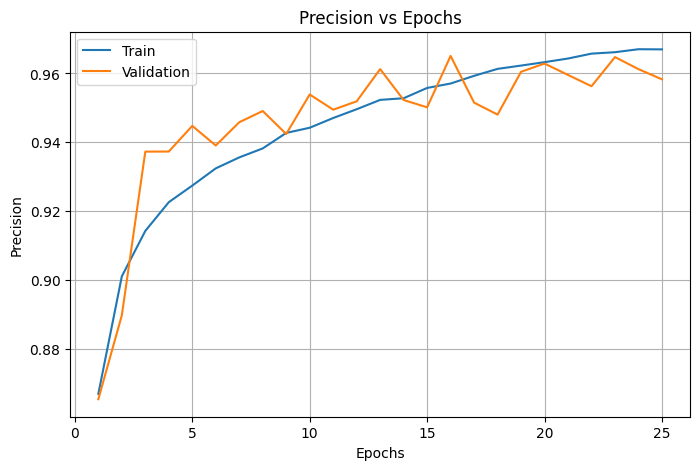

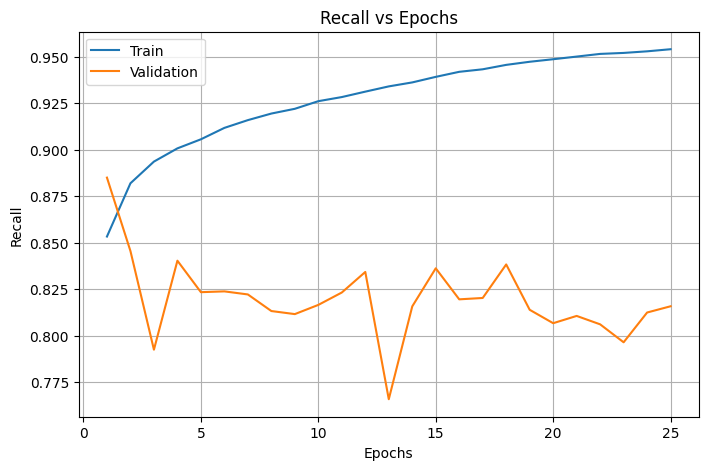

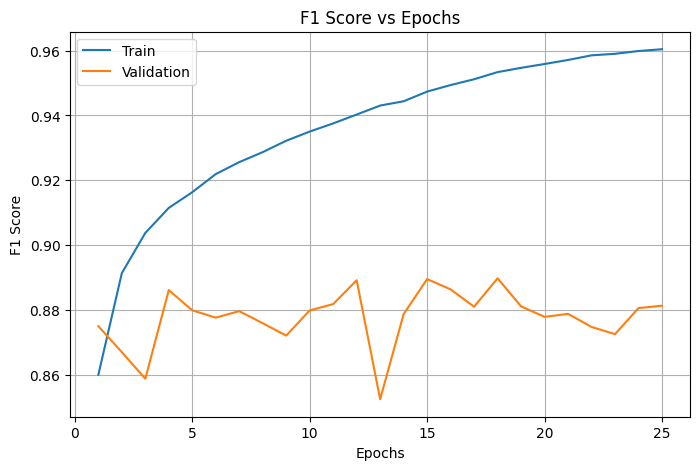

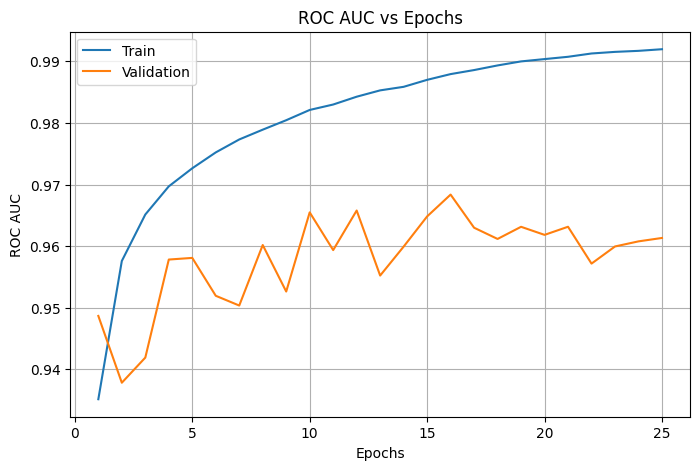

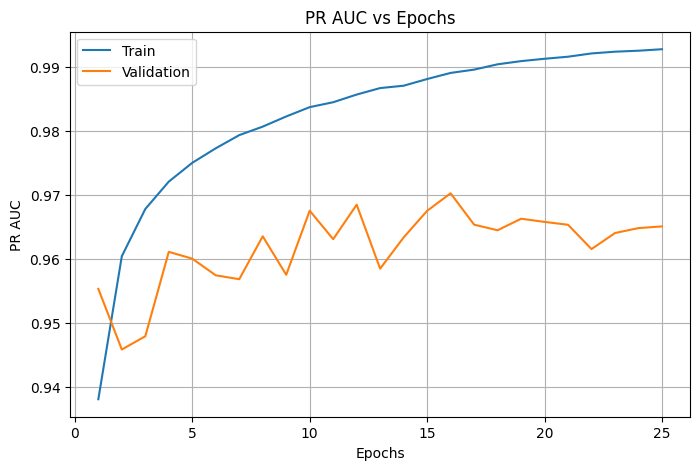

In [10]:
train_metrics = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, epochs
)

with open("metrics.json", "w") as f:
    json.dump(round_metrics(train_metrics), f, indent=4)

epochs_range = range(1, epochs + 1)

metric_names = [
    "accuracies",
    "losses",
    "precisions",
    "recalls",
    "f1s",
    "rocs",
    "prs",
]
metric_labels = [
    "Accuracy (%)",
    "Loss",
    "Precision",
    "Recall",
    "F1 Score",
    "ROC AUC",
    "PR AUC",
]

for metric, label in zip(metric_names, metric_labels):
    plt.figure(figsize=(8, 5))
    plot_metrics(epochs_range, *train_metrics[metric], label, f"{label} vs Epochs")
    plt.savefig(f"{metric}.png", bbox_inches="tight")
    plt.show()
    plt.close()